In [1]:
!pip install qiskit qiskit-aer matplotlib --upgrad


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

ambiguous option: --upgrad (--upgrade, --upgrade-strategy?)


In [2]:
# Grover's Search Algorithm using Qiskit 2.x
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator, noise
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


In [3]:
def oracle(qc, n, marked_state):
    """Constructs the oracle for the given marked state."""
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)

In [4]:
def diffuser(qc, n):
    """Implements Grover's diffusion operator."""
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))

def grover_search(marked_state, iterations=1):
    """Builds the Grover's search circuit for a given marked state."""
    n = len(marked_state)
    qc = QuantumCircuit(n, n)
    qc.h(range(n))  # Create superposition

    for _ in range(iterations):
        oracle(qc, n, marked_state)
        diffuser(qc, n)

    qc.measure(range(n), range(n))
    return qc


In [5]:
def create_noise_model():
    """Creates a realistic noise model with depolarizing and readout noise."""
    noise_model = noise.NoiseModel()

    # Depolarizing noise for 1- and 2-qubit gates
    depol1 = noise.errors.depolarizing_error(0.02, 1)  # 2% error for 1-qubit gates
    depol2 = noise.errors.depolarizing_error(0.05, 2)  # 5% error for 2-qubit gates

    # Apply noise to common gates
    noise_model.add_all_qubit_quantum_error(depol1, ['x', 'h'])
    noise_model.add_all_qubit_quantum_error(depol2, ['cx', 'mcx'])

    # Add readout (measurement) noise
    readout_error = noise.errors.ReadoutError([[0.9, 0.1],
                                               [0.1, 0.9]])  # 10% flip error
    noise_model.add_all_qubit_readout_error(readout_error)

    return noise_model

In [6]:
!pip install pylatexenc


🔍 Searching for marked state: 1010

Quantum Circuit:
     ┌───┐               ┌───┐┌───┐                    ┌───┐┌───┐                    ┌───┐┌───┐                    ┌───┐┌───┐     ┌─┐         
q_0: ┤ H ├────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────┤M├─────────
     ├───┤┌───┐       │  ├───┤├───┤┌───┐            │  ├───┤├───┤┌───┐            │  ├───┤├───┤┌───┐            │  ├───┤├───┤     └╥┘┌─┐      
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────╫─┤M├──────
     ├───┤└───┘       │  ├───┤├───┤└───┘            │  ├───┤├───┤└───┘            │  ├───┤├───┤└───┘            │  ├───┤├───┤      ║ └╥┘┌─┐   
q_2: ┤ H ├────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├─────────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────╫──╫─┤M├───
     ├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌───┐┌─┴─┐├───

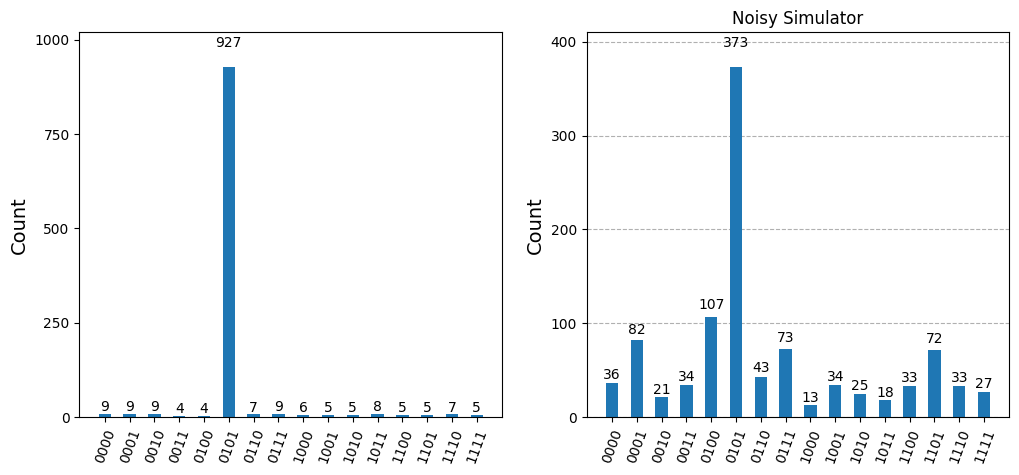


 Ideal Simulator Counts: {'1101': 5, '1010': 5, '1110': 7, '0010': 9, '0000': 9, '1100': 5, '0101': 927, '1001': 5, '1111': 5, '0001': 9, '0011': 4, '0111': 9, '1011': 8, '0100': 4, '1000': 6, '0110': 7}
 Noisy Simulator Counts: {'1011': 18, '0010': 21, '1010': 25, '0100': 107, '1110': 33, '0111': 73, '0011': 34, '0001': 82, '1111': 27, '0000': 36, '1000': 13, '0110': 43, '1101': 72, '0101': 373, '1001': 34, '1100': 33}


In [7]:
def run_grover_comparison(qc):
    """Runs Grover's search on both ideal and noisy simulators and plots results."""
    # Create simulators
    ideal_sim = AerSimulator()
    noise_model = create_noise_model()
    noisy_sim = AerSimulator(noise_model=noise_model)

    # Transpile circuits
    qc_ideal = transpile(qc, ideal_sim)
    qc_noisy = transpile(qc, noisy_sim)

    # Run simulations
    result_ideal = ideal_sim.run(qc_ideal, shots=1024).result()
    result_noisy = noisy_sim.run(qc_noisy, shots=1024).result()

    counts_ideal = result_ideal.get_counts()
    counts_noisy = result_noisy.get_counts()

    # Plot results side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_histogram(counts_ideal, ax=ax[0], title="Ideal Simulator")
    plot_histogram(counts_noisy, ax=ax[1], title="Noisy Simulator")
    plt.show()

    return counts_ideal, counts_noisy


if __name__ == "__main__":
    # --- Student can modify these values ---
    marked_state = "1010"  # Try "001", "111", "010", etc.
    iterations = 2         # Try 1, 2, or 3

    print(f"🔍 Searching for marked state: {marked_state}")

    qc = grover_search(marked_state, iterations)

    print("\nQuantum Circuit:")
    print(qc.draw(fold=-1))

    # For notebooks: display the graphical version
    qc.draw("mpl")
    plt.show()

    # --- Run both ideal and noisy versions ---
    counts_ideal, counts_noisy = run_grover_comparison(qc)

    # --- Print count results ---
    print("\n Ideal Simulator Counts:", counts_ideal)
    print(" Noisy Simulator Counts:", counts_noisy)

